In [52]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/cs/dataiku/deng/DSS_DATA/code-envs/python/python36deng/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [53]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd

In [54]:
# Example: load a DSS dataset as a Pandas dataframe
modelFolder = dataiku.Folder("model")
mappingFolder = dataiku.Folder("mapping")
imgFolder  = dataiku.Folder("scanned")

In [55]:
modelPath= modelFolder.get_path()+"/"
mappingPath=mappingFolder.get_path()+"/"
imgPath=imgFolder.get_path()+"/"

In [56]:
print(imgPath)
mappingPath

/cs/dataiku/deng/DSS_DATA/managed_datasets/CHATBOT_OCR/9SHpTVZA/


'/cs/dataiku/deng/DSS_DATA/managed_datasets/CHATBOT_OCR/MK98HL3A/'

In [57]:
import os

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
import cv2
import numpy as np
import copy
import tensorflow as tf
import matplotlib.pyplot as plt

In [58]:
border_size = 5

In [59]:
class Roi:
    def __init__(self, roi, x, y, w, h):
        self.roi = roi
        self.x = x
        self.y = y
        self.w = w
        self.h = h

In [60]:

def process_image(image):
    th = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 125, 20)
    blurred = cv2.medianBlur(th, 7)
    inverted = cv2.bitwise_not(blurred)
    eroded = cv2.erode(inverted, np.ones((1, 1), np.uint8))
    dilated = cv2.dilate(eroded, np.ones((2, 2), np.uint8))
    # cv2.imwrite('denoised.jpg', dilated)
    plt.imshow(dilated, 'gray')
    return dilated

In [61]:

def load_model(model_name):
    return keras.models.load_model(modelPath + model_name)


In [62]:

def get_labels(file_name):
    #with open('mappings/' + file_name, 'r') as mapping:
    with open(mappingPath + file_name, 'r') as mapping:
        lines = mapping.readlines()

    for i in range(len(lines)):
        lines[i] = lines[i].replace('\n', '')

    return lines

In [63]:

def get_model_and_mapping():
    return {
        1: (load_model('capital_only_model_99_39'), get_labels('capital_letters.txt')),
        2: (load_model('digit_only_model_99_43'), get_labels('digits.txt')),
        3: (load_model('letters_and_digits_bymerge_90_35'), get_labels('all_characters.txt'))
    }


In [64]:


def add_border(img):
    h, w = img.shape
    pad_h, pad_w = 0, 0
    if w > h:
        pad_h = int((w - h) / 2)
    else:
        pad_w = int((h - w) / 2)
    padded_img = cv2.copyMakeBorder(img, top=pad_h, bottom=pad_h, left=pad_w, right=pad_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_img

In [65]:

def predict_character(classifier, labels, image, text, position, choice):
    image = cv2.dilate(image, kernel=np.ones((2, 2), np.uint8), iterations=1)
    text_1 = list()
    X_list = list()
    pred_list = list()
    # cv2.imshow('Predicting Image', image)
    # cv2.waitKey(0)
    X = image.reshape(1, 784)
    X = X / 255
    X = X.reshape(X.shape[0], int(X.shape[1] ** 0.5), int(X.shape[1] ** 0.5))
    X = X[..., np.newaxis]
    pred_list.append(X)
    pred = classifier.predict(X)
    print(pred.shape)
    largest = pred.argmax()
    nbr = labels[largest]
    nbr_1 = labels[np.delete(pred, largest).argmax()]
    nbr = nbr.split(' ')
    nbr_1 = nbr_1.split(' ')
    if (choice == 3 and position > 0 and chr(int(nbr[1])).isupper()):
        text.append(chr(int(nbr[1]) + 32))
    else:
        text.append(chr(int(nbr[1])))
    text_1.append(chr(int(nbr_1[1])))
    for i, p in enumerate(pred.reshape(-1, 1)):
        print("Predicted: %c with %f" % (chr(int(labels[i].split(' ')[1])), p))
    X_list.append(X)
    return text


In [66]:


def segment(image, kernel, isPara):
    orig_image = copy.copy(image)
    # dilation
    img_dilation = cv2.dilate(image, kernel=kernel, iterations=1)
    plt.imshow(cv2.resize(img_dilation, (500, 200)), 'gray')
    # find contours
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # sort contours
    if isPara:
        sorted_ctrs = sorted(ctrs, key=lambda ctr: (cv2.boundingRect(ctr)[1], cv2.boundingRect(ctr)[0]))
    else:
        sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

    roi_list = list()

    roi_objects = []

    for i, ctr in enumerate(sorted_ctrs):
        # Get bounding box
        x, y, w, h = cv2.boundingRect(ctr)

        # Getting ROI
        roi = orig_image[y:y + h, x:x + w]
        # show ROI
        roi_list.append(roi)
        roi_objects.append(Roi(roi, x, y, w, h))
        # cv2.imshow('segment no:'+str(i), roi)
        # cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # cv2.waitKey(0)

    # cv2.imshow('marked areas', image)
    # cv2.waitKey(0)
    # print('Recognized' + text)
    return roi_list, roi_objects


In [67]:


def image_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

In [68]:


def recognize_image(imagepath, choice=1):
    (classifier, labels) = get_model_and_mapping()[choice]

    image = cv2.imread(imagepath, 0)

    image = image_resize(image, None, 1110)

    blurred = process_image(image)

    segmented_lines, lines_objects = segment(blurred, np.ones((10, 500), np.uint8), True)

    text = list()

    for line in range(len(lines_objects)):

        distances = []

        _, words_obj = segment(lines_objects[line].roi, np.ones((5, 7), np.uint8), False)

        for i in range(len(words_obj)-1):
            distances.append(words_obj[i+1].x-(words_obj[i].x+words_obj[i].w))

        minimum = maximum = 0

        try:
            minimum = np.min(distances)
            maximum = np.max(distances)
        except ValueError:
            pass

        for i in range(len(words_obj)):
            padded_img = add_border(words_obj[i].roi)
            padded_img = cv2.resize(padded_img, (28 - (border_size * 2), 28 - (border_size * 2)),
                                    interpolation=cv2.INTER_AREA)
            padded_img = cv2.copyMakeBorder(padded_img, border_size, border_size, border_size, border_size,
                                            cv2.BORDER_CONSTANT, value=[0, 0, 0])
            padded_img[padded_img>50] = 255;
            text = predict_character(classifier, labels, padded_img, text, i, choice)
            print(text)
            
            print(distances)

            if minimum >= maximum/2:
                continue

            if i < len(words_obj)-1 and distances[i] > maximum/2:
                text.append(' ')
        
        if line <  len(lines_objects)-1:
            text.append('\n')

    print(''.join(text))
    
    return ''.join(text)



(1, 26)
Predicted: A with 0.000000
Predicted: B with 0.000000
Predicted: C with 0.000000
Predicted: D with 0.000000
Predicted: E with 0.000000
Predicted: F with 0.000000
Predicted: G with 0.000000
Predicted: H with 0.999999
Predicted: I with 0.000000
Predicted: J with 0.000000
Predicted: K with 0.000000
Predicted: L with 0.000000
Predicted: M with 0.000001
Predicted: N with 0.000000
Predicted: O with 0.000000
Predicted: P with 0.000000
Predicted: Q with 0.000000
Predicted: R with 0.000000
Predicted: S with 0.000000
Predicted: T with 0.000000
Predicted: U with 0.000000
Predicted: V with 0.000000
Predicted: W with 0.000000
Predicted: X with 0.000000
Predicted: Y with 0.000000
Predicted: Z with 0.000000
['H']
[76, 60, 29, 27]
(1, 26)
Predicted: A with 0.000000
Predicted: B with 0.000000
Predicted: C with 0.000000
Predicted: D with 0.000000
Predicted: E with 1.000000
Predicted: F with 0.000000
Predicted: G with 0.000000
Predicted: H with 0.000000
Predicted: I with 0.000000
Predicted: J wit

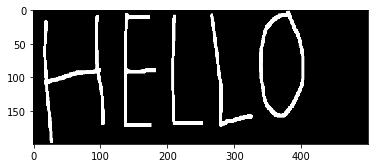

In [71]:
hello = imgPath+"hello.png"
if __name__ == '__main__':
    recognize_image(hello)